# Multi-Step Prediction Model using Simple RNN
RNN (Recurrent Neural Network) is a deep learning model architecture designed to effectively model sequence data. RNNs maintain an internal state that allows them to process sequences of inputs. This makes them well-suited for tasks such as Time Series Prediction.

RNN have loops that allow information to persist, making them capable of processing sequences of data. This loop enables information to be passed from one step of the network to the next. This ability to retain information about previous input data makes RNN capable of capturing temporal dependencies in the data.

Notebook Author : [Davian Benito Djojokusumo](https://www.linkedin.com/in/davian-benito/)

### Import Library and Dataset
Here we're using tvDatafeed library to help scrap and get the stock price data from the [TradingView](https://id.tradingview.com/) website.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras import callbacks

np.random.seed(42)
tf.random.set_seed(42)

import tensorflow as tf
from tvDatafeed import TvDatafeed,Interval

In [ ]:
# Account for TradingView - change it with your own TradingView account info
username = 'Davv42'
password = 'xxxx'

tv=TvDatafeed(username, password)
data = tv.get_hist(symbol='BBCA',exchange='IDX',interval=Interval.in_daily ,n_bars=10000)

In [ ]:
data.head()

,symbol,open,high,low,close,volume
datetime,,,,,,
2000-05-31 09:00:00,IDX:BBCA,35.0,36.250,35.0,35.000,6.727400e+09
2000-06-02 09:00:00,IDX:BBCA,35.0,35.625,35.0,35.000,1.525400e+09
2000-06-05 09:00:00,IDX:BBCA,35.0,35.625,35.0,35.625,1.536000e+08
2000-06-06 09:00:00,IDX:BBCA,35.0,35.625,35.0,35.625,7.260000e+07
2000-06-07 09:00:00,IDX:BBCA,35.0,35.625,35.0,35.625,7.940000e+07


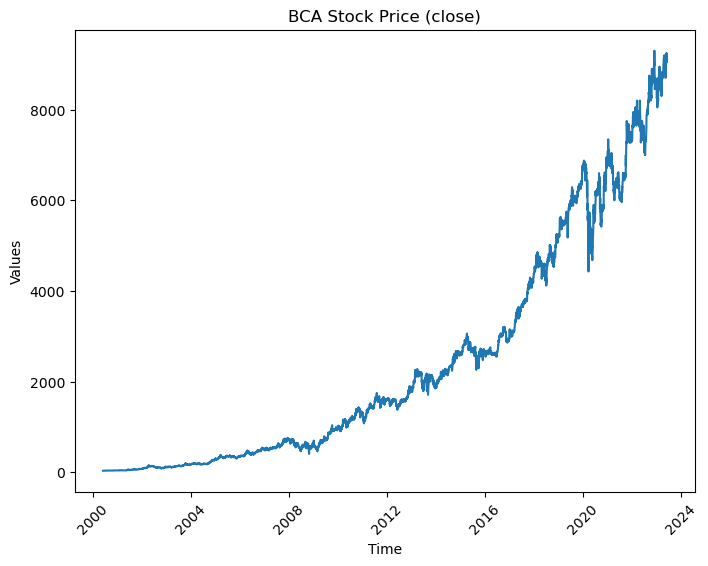

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# We're really like to just focus on the closing price of the data because its the most impact data for trading.
ax.plot(data.close)
ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.set_title('BCA Stock Price (close)')
plt.xticks(rotation=45)

plt.show()

### Preprocess Data
Performs standard preprocess data to make sure its compatible

In [ ]:
# Checking the data types
data.dropna(axis=0)
data.dtypes

symbol     object
open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object

In [ ]:
# Use the related features for prediction
data.drop('symbol', axis=1, inplace=True)
data = data.reset_index()
data.drop('datetime', axis=1, inplace=True)
data

,open,high,low,close,volume
0,35.0,36.250,35.0,35.000,6.727400e+09
1,35.0,35.625,35.0,35.000,1.525400e+09
2,35.0,35.625,35.0,35.625,1.536000e+08
3,35.0,35.625,35.0,35.625,7.260000e+07
4,35.0,35.625,35.0,35.625,7.940000e+07
...,...,...,...,...,...
5568,9100.0,9150.000,9050.0,9050.000,6.205820e+07
5569,9175.0,9200.000,9100.0,9150.000,5.567590e+07
5570,9250.0,9250.000,9075.0,9150.000,7.914820e+07
5571,9200.0,9325.000,9150.0,9250.000,1.111269e+08


In [ ]:
# Normalize the data    - Note that this approach is a bit flawed because later we gonna split the data for our test data.
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

##### Alternate code, but still a little bit off

In [ ]:
# # Normalize the data -- (?)
# scaler_X = MinMaxScaler()
# train_X = scaler_X.fit_transform(train_X)
# pred_X = scaler_X.transform(pred_X)

# scaler_y = MinMaxScaler()
# train_y = scaler_y.fit_transform(train_y)
# pred_y = scaler_y.transform(pred_y)

### Data Engineering
Transform and format the sequence data to a 3 Dimentional X_train data, where **x** is the numbers of input data for each forecast (sequence_length), **y** is the numbers of features used, and **z** is the numbers of 2D (x, y) training data to be used.

In here we're gonna try to predict the `close` data for our y_train data.

In [ ]:
# This filler neccesary because when we try to predict y for multi-step forecast, some of the y values on the training data will be missing because the data aren't available yet.
def create_filler(steps):
    Y = []
    for i in range(steps):
        Y.append(0)
    return np.array(Y)


# Data reformat function
def create_sequences(data, seq_length, steps, filler, multiple_steps=False):
    X, Y = [], []
    for i in range(seq_length, data.shape[0]):
        X.append(data[i-seq_length:i])
        if(i+steps > data.shape[0] and multiple_steps):
            Y.append(filler)
        else:
            Y.append(data[i:i+steps, 3])
    return np.array(X), np.array(Y)

seq_length = 10
steps = 1
filler = create_filler(steps)
X, y = create_sequences(data, seq_length, steps, filler)

In [ ]:
# Try to predict the 3 last data using 1 step forecast
n_pred = 3

train_X = X[:-n_pred]
train_y = y[:-n_pred]

pred_X = X[-n_pred:]
pred_y = y[-n_pred:]

This is the most important part for us to understand the structure of this forecasting data. The X_train consist of 5560 input data to be train, each input data is 10 sequence long, with 5 feature. Then y_train is only the `close` value for the latest/most-recent data on the sequence.

For the data test, we're only using 3 input data

In [ ]:
print('shape data training : X:{}, y:{}. \nshape data test : X:{}, y:{}.'.format(train_X.shape, train_y.shape, pred_X.shape, pred_y.shape))

shape data training : X:(5560, 10, 5), y:(5560, 1). 
shape data test : X:(3, 10, 5), y:(3, 1).


### Create RNN Model

In [ ]:
# Basic early stopping for the model
early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001,
    monitor='loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
# We're using the sequential class and the SimpleRNN layer from the tensorflow keras lib
model = Sequential()

model.add(SimpleRNN(units=256, activation='relu', input_shape=(train_X.shape[1], 5), return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(SimpleRNN(units=256, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=steps))

model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(train_X, train_y, epochs=30, batch_size=128, callbacks=[early_stopping])

Epoch 1/30
44/44 [==============================] - 3s 23ms/step - loss: 0.0096
Epoch 2/30
44/44 [==============================] - 1s 22ms/step - loss: 0.0016
Epoch 3/30
44/44 [==============================] - 1s 22ms/step - loss: 0.0013
Epoch 4/30
44/44 [==============================] - 1s 22ms/step - loss: 0.0010
Epoch 5/30
44/44 [==============================] - 1s 22ms/step - loss: 9.5744e-04
Epoch 6/30
44/44 [==============================] - 1s 23ms/step - loss: 9.4203e-04
Epoch 7/30
44/44 [==============================] - 1s 22ms/step - loss: 9.1323e-04
Epoch 8/30
44/44 [==============================] - 1s 22ms/step - loss: 8.5113e-04
Epoch 9/30
44/44 [==============================] - 1s 22ms/step - loss: 0.0010
Epoch 10/30
44/44 [==============================] - 1s 22ms/step - loss: 7.6753e-04
Epoch 11/30
44/44 [==============================] - 1s 22ms/step - loss: 7.0953e-04
Epoch 12/30
44/44 [==============================] - 1s 23ms/step - loss: 7.7328e-04
Epoch 13/

In [ ]:
pred_result = model.predict(pred_X)
print(pred_result)

1/1 [==============================] - 0s 222ms/step
[[0.9407749]
 [0.9436168]
 [0.9480471]]


In [ ]:
print(pred_y)

[[0.98381004]
 [0.99460335]
 [0.97301673]]


### Result Evaluation
Here we try to compare the predicted values with the true values.

In [ ]:
def compare_plot(actual, predict):
    fig, ax = plt.subplots(figsize=(16, 6))

    ax.plot(actual, label='Actual')
    ax.plot(predict, label='Predicted')
    plt.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax.set_title('BCA Stock Price (close)')
    plt.xticks(rotation=45)

    plt.show()

174/174 [==============================] - 1s 4ms/step


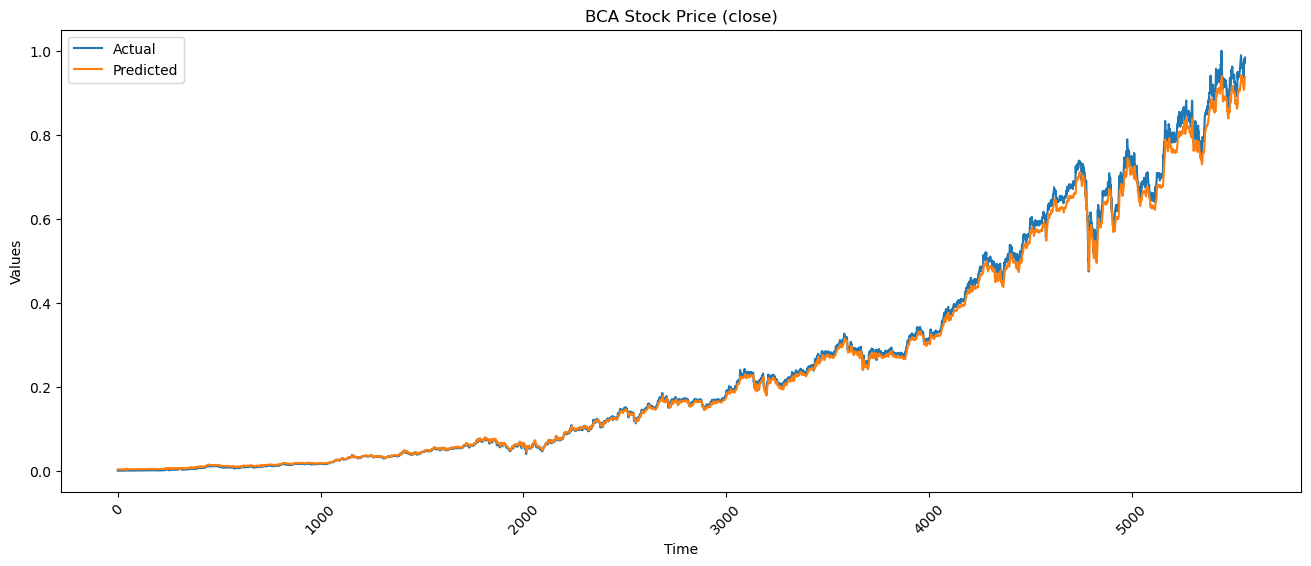

In [ ]:
# Train data result
predicted = model.predict(train_X)
compare_plot(train_y, predicted)

1/1 [==============================] - 0s 29ms/step


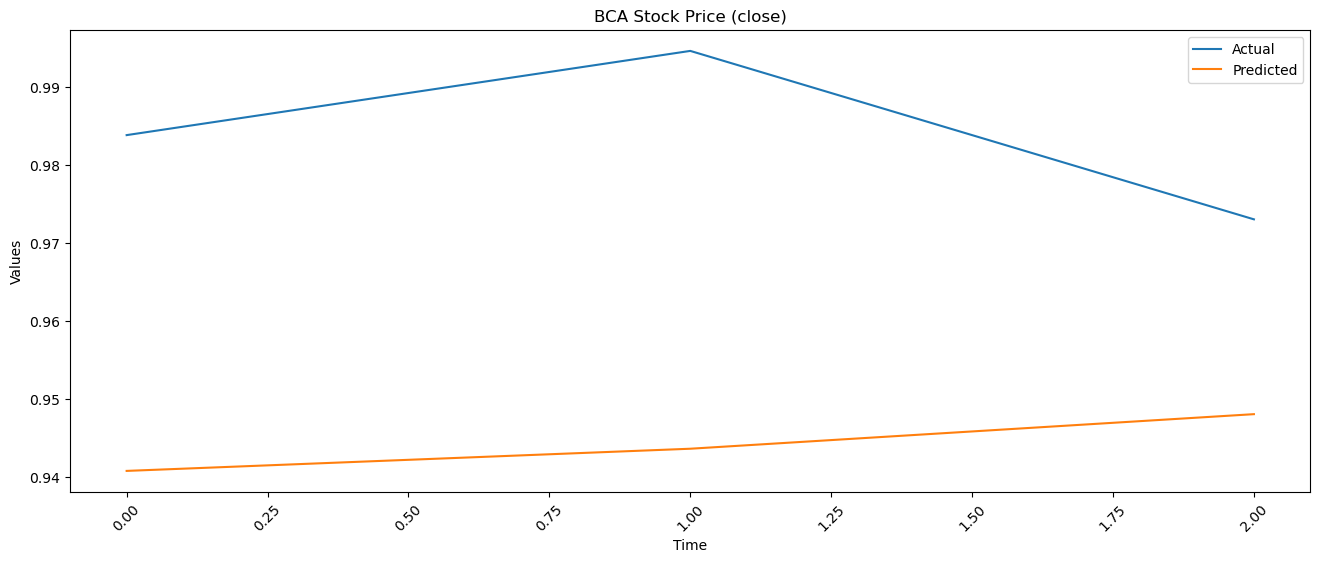

In [ ]:
# The test data result
predicted = model.predict(pred_X)
compare_plot(pred_y, predicted)

### Using Multiple Steps Predictions
Here we try to use multi-step predictions where the model will predict 3-steps data directly.

In the shape output, we can see that the y_train value is of 5562 input data, each with 3 `close` value that is trying to be predicted.

In [ ]:
seq_length = 10
steps = 3 # The variables change..
filler = create_filler(steps)
X, y = create_sequences(data, seq_length, steps, filler, multiple_steps=True)

n_pred = 1

train_X = X[:-n_pred]
train_y = y[:-n_pred]

pred_X = X[-n_pred:]
pred_y = y[-steps]

print('shape data training : X:{}, y:{}. \nshape data test : X:{}, y:{}.'.format(train_X.shape, train_y.shape, pred_X.shape, pred_y.shape))

shape data training : X:(5562, 10, 5), y:(5562, 3). 
shape data test : X:(1, 10, 5), y:(3,).


In [ ]:
model = Sequential()

model.add(SimpleRNN(units=256, activation='relu', input_shape=(train_X.shape[1], 5), return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(SimpleRNN(units=256, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=steps))

model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(train_X, train_y, epochs=30, batch_size=128, callbacks=[early_stopping])

Epoch 1/30
44/44 [==============================] - 3s 24ms/step - loss: 0.0110
Epoch 2/30
44/44 [==============================] - 1s 22ms/step - loss: 0.0025
Epoch 3/30
44/44 [==============================] - 1s 23ms/step - loss: 0.0020
Epoch 4/30
44/44 [==============================] - 1s 23ms/step - loss: 0.0017
Epoch 5/30
44/44 [==============================] - 1s 23ms/step - loss: 0.0016
Epoch 6/30
44/44 [==============================] - 1s 23ms/step - loss: 0.0016
Epoch 7/30
44/44 [==============================] - 1s 23ms/step - loss: 0.0013
Epoch 8/30
44/44 [==============================] - 1s 22ms/step - loss: 0.0012
Epoch 9/30
44/44 [==============================] - 1s 22ms/step - loss: 0.0014
Epoch 10/30
44/44 [==============================] - 1s 22ms/step - loss: 0.0012
Epoch 11/30
44/44 [==============================] - 1s 22ms/step - loss: 0.0012
Epoch 12/30
44/44 [==============================] - 1s 22ms/step - loss: 0.0012
Epoch 13/30
44/44 [==================

In [ ]:
predicted = model.predict(pred_X).reshape(-1)
predicted

1/1 [==============================] - 0s 20ms/step


array([0.96764725, 0.96682185, 0.976883  ], dtype=float32)

In [ ]:
pred_y

array([0.98381004, 0.99460335, 0.97301673])

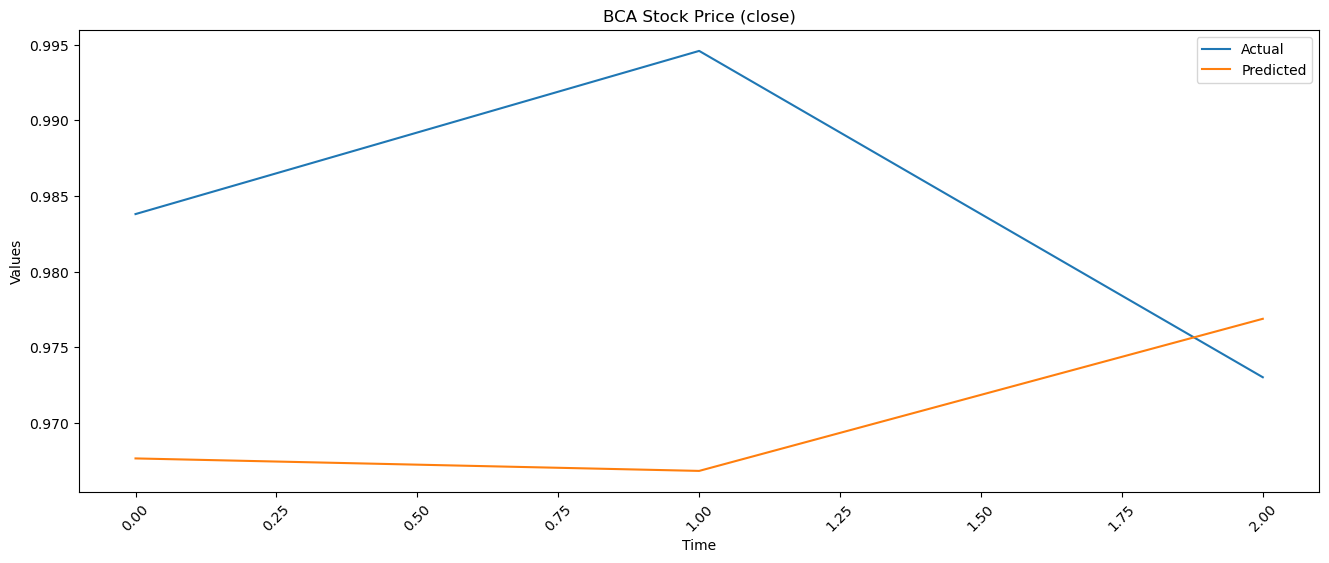

In [ ]:
# The result for the last 3 input data stock price
compare_plot(pred_y, predicted)